# GEOtiled Concurrency Optimization Notebook

<p style="text-align:center">
    <img src="images/concurrency_optimization.png" width="800"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>Concurrency Optimization
</p>

This notebook showcases the changes to the utilization of concurrency within GEOtiled to provide improvements to execution time.

## Preconfiguration

Import the needed libraries to run the code blocks.

In [1]:
import crop_functions as cp
import mosaic_functions as ms
import compute_functions as cm
import geotiled
import shutil
import time

Modify the testing parameters below to change the data and size of tiles created. 

Do not specify tile sizes that would cause the final file count to exceed the number of cores available for the best performance results.

In [2]:
# The working directory to store files in
working_directory = '/media/volume/geotiled-saga/concurrency_test'
geotiled.set_working_directory(working_directory)

# Size of tiles to produce specified as a list of [x,y] values (units of pixels)
tile_sizes = [[18274,16862],[18274,8431],[9137,8431],[9137,4216],[4569,4216]]

# Data to download
resolution = '30m'
region = 'TN'

# Number of runs to do (execution times for each tile size will be averaged at the end)
runs = 1

Create a CSV to store the results to.

In [3]:
file = open('results.csv', 'w')
file.write('method,tile_size,run_number,execution_time\n')
file.close()

## Initialization

Download and preprocess the data.

In [4]:
# Download the desired data
geotiled.fetch_dem(shapefile=region, dataset=resolution, save_to_txt=False, download=True)

# Mosaic DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation')

# Reproject mosaic into computable format
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918')

Downloading: 100%|█████████████████████████████████████████████| 58.1M/58.1M [00:02<00:00, 26.3MB/s]
Downloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [00:17<00:00, 95.8MB/s]


## Separated Concurrency

Takes the crop, compute, and buffer crop steps of GEOtiled and computes them with separate multiprocessing pools.

In [5]:
for ts in tile_sizes:
    for i in range(runs):
        # Perform mosaic
        start_time = time.time()
        cp.parallel_crop('elevation.tif', 'elevation_tiles', ts[0], ts[1])
        cm.parallel_compute('elevation_tiles', ['slope'])
        ms.crop_buffer_regions('slope_tiles', 'unbuffered_slope_tiles')
        run_time = time.time() - start_time

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"separated,{ts[0]}x{ts[1]},{i},{run_time}\n")
        file.close()

## Unified Concurrency

Takes the crop, compute, and buffer crop steps and puts them all into a single multiprocessing pool to minimize overhead.

In [6]:
# Cleanup previous files to prevent issues with this test
shutil.rmtree('elevation_tiles')
shutil.rmtree('slope_tiles')
shutil.rmtree('unbuffered_slope_tiles')

In [7]:
for ts in tile_sizes:
    for i in range(runs):
        # Perform mosaic
        start_time = time.time()
        cm.parallel_crop_and_compute('elevation.tif', ts[0], ts[1], ['slope'])
        run_time = time.time() - start_time

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"unified,{ts[0]}x{ts[1]},{i},{run_time}\n")
        file.close()

## Visualize Results

Plot execution time of both concurrency methods.

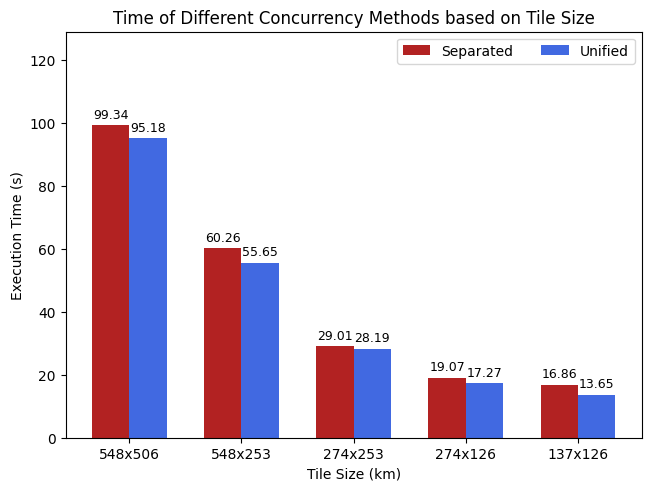

In [8]:
cm.plot_concurrency_results('results.csv')

### End of Notebook